# Linear Decoder


How does using a linear decoder impact the results of training?

Look at:
1. Clustering metrics
2. Factor loadings and how they correspond to different "co-regulated" genes

In [2]:
# system
import sys, os
sys.path.insert(0,'../BIVI/')
sys.path.insert(0, './analysis_scripts/')


# numbers
import numpy as np
import pandas as pd

# sc 
import scanpy as sc
import anndata

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# # biVI
import biVI
import scvi
print(scvi.__version__)

# for PCA
import sklearn
from sklearn.metrics import silhouette_score 


from calculate_metrics import *

# # reproducibility
scvi._settings.ScviConfig.seed=(12623)
torch.manual_seed(12623)
np.random.seed(12623)

Global seed set to 0
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


0.18.0


In [3]:
# load in data
# first load in data
adata = anndata.read_loom('../../data/allen/B08_processed_hv.loom')

# make variable names unique 
adata.var_names_make_unique()

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# remove cell types with fewer than 10 cells !
adata = adata[(adata.obs['subclass_label'] != 'L5 ET') & (adata.obs['subclass_label'] != 'VLMC')
    & (adata.obs['subclass_label'] != 'L6 IT Car3') & (adata.obs['subclass_label'] != 'SMC')]

adata = adata.copy()
# extract cell types for coloring
cell_types = np.array(adata.obs['Cell Type'])


In [5]:
# load in models
model_nonlinear = biVI.biVI.load("../../results/Bursty_B08_processed_hv_MODEL", adata=adata, use_gpu = True)
model_linear = biVI.biVI.load("../../results/Bursty_B08_processed_hv_linear_MODEL", adata=adata, use_gpu = True)

INFO     File ../../results/Bursty_B08_processed_hv_MODEL/model.pt already downloaded                              
{'n_input': 4000, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear
INFO     File ../../results/Bursty_B08_processed_hv_linear_MODEL/model.pt already downloaded                       


/home/tara/.local/lib/python3.8/site-packages/scvi/model/base/_utils.py:142: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(
/home/tara/.local/lib/python3.8/site-packages/scvi/model/base/_utils.py:142: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


{'n_input': 4000, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: linear


In [6]:
# PCA of latent space

# get latent representations
X_nonlinear = model_nonlinear.get_latent_representation(adata)
X_linear = model_linear.get_latent_representation(adata)


# declare PCA classes, learn top 2 components to plot
PCA_nonlinear = sklearn.decomposition.PCA(n_components = 2)
PCA_linear = sklearn.decomposition.PCA(n_components = 2)
PCA_full = sklearn.decomposition.PCA(n_components = 2)

# fit and transform latent spaces
components_nl = PCA_nonlinear.fit_transform(X_nonlinear)
components_l = PCA_linear.fit_transform(X_linear)
components_full = PCA_full.fit_transform(adata.X.todense())

/usr/local/lib/python3.8/dist-packages/scikit_learn-1.0.1-py3.8-linux-x86_64.egg/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [7]:
# data frames for nice plotting
df_nonlinear = pd.DataFrame({'PCA_1' : components_nl[:,0], 'PCA_2' : components_nl[:,1], 'Cell Type' : cell_types})
df_linear = pd.DataFrame({'PCA_1' : components_l[:,0], 'PCA_2' : components_l[:,1], 'Cell Type' : cell_types})
df_full = pd.DataFrame({'PCA_1' : components_full[:,0], 'PCA_2' : components_full[:,1], 'Cell Type' : cell_types})

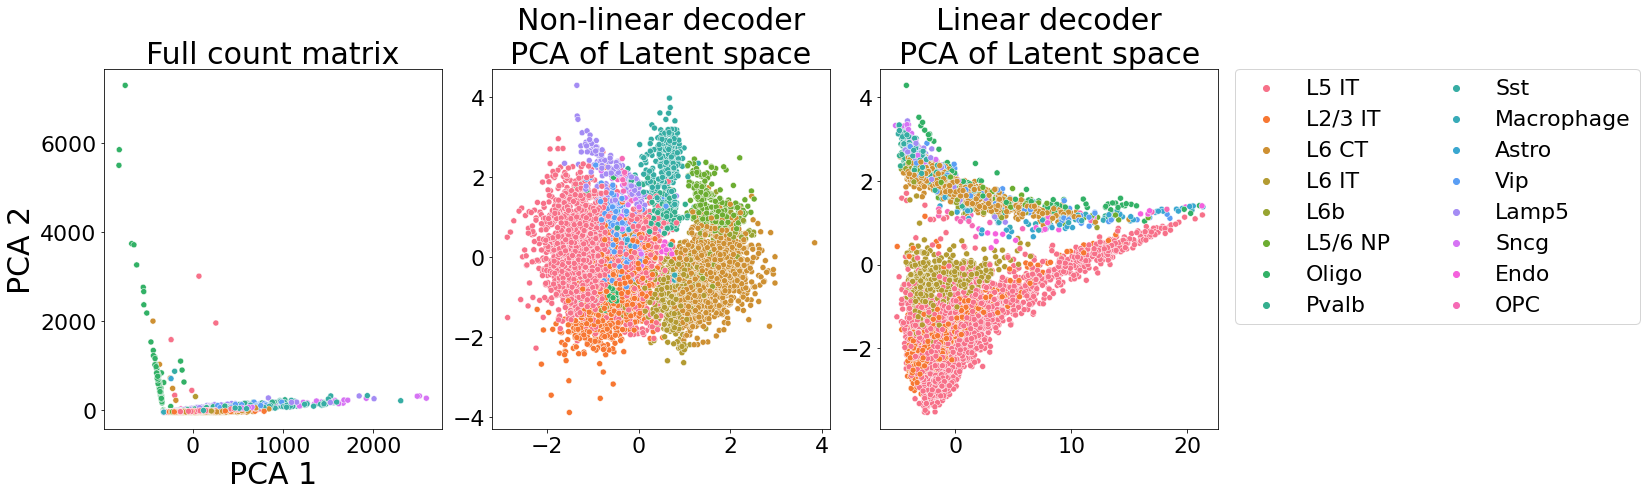

In [8]:
fig, ax = plt.subplots(1,3,figsize = (23,7))

sns.scatterplot(data = df_full, x = 'PCA_1', y ='PCA_2', hue = 'Cell Type', ax = ax[0], legend = False)
sns.scatterplot(data = df_nonlinear, x = 'PCA_1', y ='PCA_2', hue = 'Cell Type', ax = ax[1], legend = False)
sns.scatterplot(data = df_linear, x = 'PCA_1', y ='PCA_2', hue = 'Cell Type', ax = ax[2])

plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0, fontsize = 22, ncol = 2)
ax[0].set_xlabel('PCA 1', fontsize = 30)
ax[0].set_ylabel('PCA 2', fontsize = 30)
# ax[1].set_xlabel('PCA 1', fontsize = 30)
# ax[1].set_ylabel('PCA 2', fontsize = 30)
# ax[2].set_xlabel('PCA 1', fontsize = 30)
# ax[2].set_ylabel('PCA 2', fontsize = 30)
ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[1].tick_params(axis='both', which='major', labelsize=22)
ax[2].tick_params(axis='both', which='major', labelsize=22)

ax[1].set(ylabel=None,xlabel=None)
ax[2].set(ylabel=None,xlabel=None)

'My Title\n' + r'$\alpha - \omega$ are LaTeX Markup'

ax[0].set_title('Full count matrix', fontsize = 30)
ax[1].set_title('Non-linear decoder\n' + r'PCA of Latent space', fontsize = 30, wrap=True)
ax[2].set_title('Linear decoder\n' + r'PCA of Latent space', fontsize = 30, wrap=True)
plt.tight_layout()



plt.savefig('../../results/B08_processed_hv_figs/PCA_nonlin_vs_lin.png',bbox_inches='tight')

# Clustering metrics on full vs. linear vs. nonlinear latent spaces

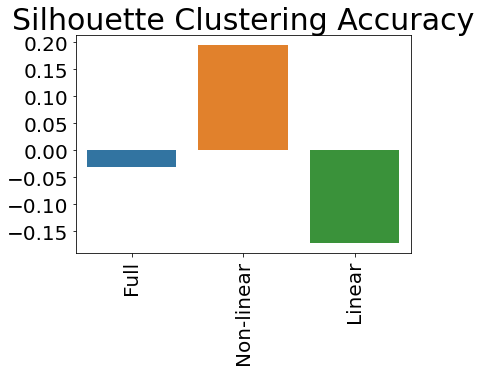

In [102]:
# n samples by n features for ss
ss_dict = {}


ss_dict['Full'] = [silhouette_score(np.array(adata.X.todense()), cell_types)]
ss_dict['Non-linear'] = [silhouette_score(X_nonlinear, cell_types)]
ss_dict['Linear'] = [silhouette_score(X_linear, cell_types)]



df_plot = pd.DataFrame(ss_dict).melt()
sns.barplot(data = df_plot,x = 'variable', y ='value')
plt.title('Silhouette Clustering Accuracy',fontsize= 30)
plt.ylabel('Silhouette Value',fontsize= 30)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(fontsize = 20, rotation = 90)
plt.yticks(fontsize = 20);
#plt.ylim(0,1)
#plt.savefig(f'../../results/{name}_figs/silhouette_{index}.png',bbox_inches='tight');

In [298]:
def l2_norm(x,y):
    
    a = (x-y)**2
    l2 = np.sqrt(np.sum(a))
    
    return(l2)

def get_intra_cluster_distances(X,cluster_assignments,return_all = False):
    ''' Get distance to cluster mean for each cell.
    -----
    params:
    latent_spaces : np array, size samples x features
    
    cluster_assignments : np array or list, size samples
    
    return_all : return distance to mean of cluster for ALL cells, default FALSE
    
    (if FALSE, returns AVERAGE distance to mean for each cluster assignment)
    -----
    
    returns:
    
    av_distance_to_mean : size n_clusters
    
    cluster_var : variance in av_distance_to_mean, size n_clusters
    
    if return_all == TRUE , also returns distances_to_mean : size # samples
    '''
    
    # declare array to hold all distances
    all_distances = np.zeros(X.shape[0])
    
    # declare array to hold average distances per cluster
    cluster_assignments = np.array(cluster_assignments)
    unique_clusters = np.unique(cluster_assignments)
    
    cluster_distances = np.zeros(len(unique_clusters))
    
    # declare array to hold average variances per cluster
    cluster_variances = np.zeros(len(unique_clusters))
    
    # how many cells have we calculated distances for? 
    cells_finished = 0
    
    # now go through each cluster and calculate distance between mean of that cluster and the vector
    for i,cluster in enumerate(unique_clusters):
        
        # subset to get samples in specific cluster
        X_subset = X[cluster_assignments == cluster]
        
        # take average across all samples in the cluster of the feature values
        cluster_mean = np.mean(X_subset,axis=0)
    
        # find the distance between samples in X_subset and the cluster mean
        distances_ = np.array([l2_norm(vec,cluster_mean) for vec in X_subset])
        
        # append or add distances to distance array
        all_distances[cells_finished : (cells_finished+X_subset.shape[0])] = distances_
        cells_finished += X_subset.shape[0]
        
        # average cluster distance
        cluster_distances[i] = np.mean(distances_)
        
        # variances
        cluster_variances[i] = np.var(distances_)
    
    cluster_variances = cluster_variances[cluster_variances != 0]
    cluster_distances = cluster_distances[cluster_distances != 0]
    all_distances = all_distances[all_distances != 0]
        
    if return_all == True:
        return(cluster_distances,cluster_variances,all_distances)
    
    else:
        return(cluster_distances,cluster_variances)

In [299]:
def get_inter_cluster_distances(X,cluster_assignments):
    ''' Gets distances between all cluster means. 
    --------
    params:
    X : size samples by features
    cluster assignments: clusters of samples in X
    
    -------
    returns:
    inter_cluster_distances : matrix size cluster by cluster of distances between each cluster
    '''
        
        
    cluster_assignments = np.array(cluster_assignments)
    unique_clusters = np.unique(cluster_assignments)
    
    # array to hold mean vectors for each cluster
    cluster_means = np.ones((len(unique_clusters),X.shape[1]))
    
    # array to hold inter cluster distances
    inter_cluster_distances = np.ones((len(unique_clusters),len(unique_clusters)))
    
     # calculate each cluster mean
    for i,cluster in enumerate(unique_clusters):
        
        # subset to get samples in specific cluster
        X_subset = X[cluster_assignments == cluster]
        
        # take average across all samples in the cluster of the feature values
        cluster_mean = np.mean(X_subset,axis=0)
        cluster_means[i,:] = cluster_mean
    
    for i in range(len(unique_clusters)):
        
        for j in range(len(unique_clusters)):
            
            inter_cluster_distances[i,j] = l2_norm(cluster_means[i],cluster_means[j])
            
    return(inter_cluster_distances)

In [300]:
# create a dictionary with the latent spaces 
setups_to_compare = ['Full','Non-linear','Linear']

    
# define dictionary of distances for each model
distance_dict = {ls : {} for ls in setups_to_compare}
distance_dict_plot = {ls : {} for ls in setups_to_compare}

In [301]:
cluster_assignments = cell_types

In [307]:
setups_to_compare = ['Full','Non-linear','Linear']
spaces = [np.array(adata.X.todense()),X_nonlinear,X_linear]
# spaces = [X_nonlinear,X_linear]

for i,setup in enumerate(setups_to_compare):
    X_latent = spaces[i]
    print(X_latent.shape)

    cluster_distances,cluster_variances = get_intra_cluster_distances(X_latent,cluster_assignments)
    inter_cluster_matrix = get_inter_cluster_distances(X_latent,cluster_assignments)
    distance_dict[setup]['Intra-Cluster Distance to Mean'] = cluster_distances
    distance_dict[setup]['Intra-Cluster Variance'] = cluster_variances
    distance_dict[setup]['Inter-Cluster Distance between Means'] = inter_cluster_matrix
    distance_dict[setup]['Fano Factor'] = cluster_variances/cluster_distances 

    
    distance_dict_plot[setup]['Average Intra-Cluster Distance'] = np.mean(cluster_distances)
    distance_dict_plot[setup]['Average Intra-Cluster Variance'] = np.mean(cluster_variances)
    distance_dict_plot[setup]['Average Inter-Cluster Distance'] = np.mean(inter_cluster_matrix[inter_cluster_matrix != 0])
    distance_dict_plot[setup]['Average Fano Factor'] = np.mean(cluster_variances/cluster_distances)

(6398, 4000)
(6398, 10)
(6398, 10)


In [314]:
distance_df = pd.DataFrame(distance_dict_plot).transpose

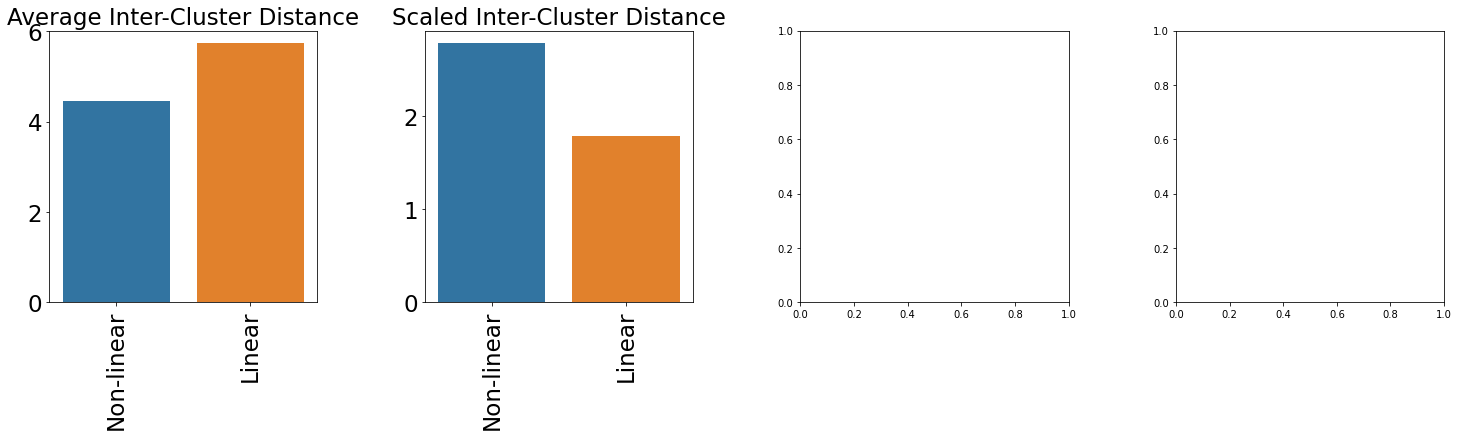

In [305]:
metrics = [#'Average Intra-Cluster Distance',
#            'Average Intra-Cluster Variance',
           'Average Inter-Cluster Distance']

fs = 23

fig,axes = plt.subplots(1,4,figsize = (25,5),gridspec_kw={'wspace':0.4, 'hspace':0.0})

for i,metric in enumerate(metrics):
    
    dict_plot = {}
    ax = axes[i]
    setups = setups_to_compare
    metric_list = [distance_dict_plot[setup][metric] for setup in setups]
    dict_plot['setup'] = setups
    dict_plot['metric'] = metric_list
    df_plot = pd.DataFrame(dict_plot)
    sns.barplot(ax = ax, data = df_plot, x = 'setup', y ='metric')
    ax.set_title(f'{metric}',fontsize = fs, wrap=True)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    #plt.xlabel('Latent Space Method')
    ax.set_xticklabels(labels = setups, rotation = 90, fontsize = fs)
    ax.tick_params(axis='y', which='both', labelsize=fs)

ax= axes[i+1]

metric_list = [distance_dict_plot[setup]['Average Inter-Cluster Distance']/distance_dict_plot[setup]['Average Intra-Cluster Distance']
               for setup in setups]
dict_plot['setup'] = setups
dict_plot['metric'] = metric_list
df_plot = pd.DataFrame(dict_plot)
sns.barplot(ax = ax, data = df_plot,x = 'setup', y ='metric')
ax.set_title(f'Scaled Inter-Cluster Distance',fontsize = fs)
ax.set_ylabel(f'value',fontsize=fs)
ax.set_xticklabels(labels = setups, rotation = 90, fontsize = fs)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.tick_params(axis='y', which='both', labelsize=fs)
    
plt.tight_layout()
#plt.savefig(f'../../results/{name}_figs/clustering_metrics_{index}.png',bbox_inches='tight');

# Nearest neighbor accuracy

In [311]:
metric_dict = {}

for i,setup in enumerate(setups_to_compare):
    metric_dict[setup] = nn_percentages(spaces[i],cluster_assignments)

In [312]:
def get_df_plot(metric_df,metric):
  ''' Returns a dataframe in an easily plot-able format given metric_df and the metric targeted to plot. 
  '''

  plot_dict = {}
  for setup in metric_df.keys():

    setup_df = metric_df[setup]
    if metric in setup_df.keys():
      plot_dict[setup[:-13]] = setup_df[metric]
    df_plot = pd.DataFrame(plot_dict)
 
  return(df_plot)

def plot_metrics(metric_dict,metrics,fs=fs,zoom=None):
    
  fig,axes = plt.subplots(1,len(metrics),figsize= (10*len(metrics),10))

  #plt.xticks(rotation=90)
  for i,m in enumerate(metrics):
    if len(metrics) == 1:
        ax = axes
    else:
        ax = axes[i]
    plot_df = get_df_plot(metric_dict,m)
    _ = sns.violinplot(x="variable", y="value", data=plot_df.melt().dropna(),ax=ax,palette=color_list)

    #ax.set_title(f'{m}',fontsize=25)
    ax.tick_params('x',labelrotation=90)
    if zoom is not None:
        ax.set_ylim(0,100)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.tick_params(axis='x', which='both', labelsize=30)
    ax.tick_params(axis='y', which='both', labelsize=fs)
    
      #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


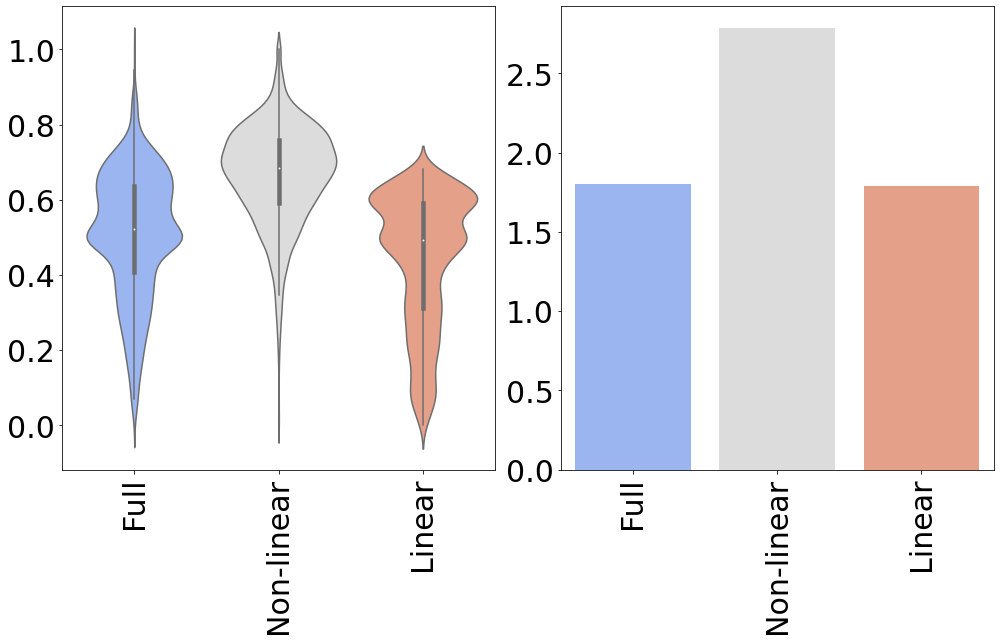

In [366]:
plot_df = pd.DataFrame(metric_dict)

fig,ax = plt.subplots(1,2,figsize= (14,9))
# plot_metrics(metric_dict,['MSE'],fs = 20)

_ = sns.violinplot(x="variable", y="value", data=plot_df.melt().dropna(),ax=ax[0],
                   palette = "coolwarm")

#ax.set_title(f'{m}',fontsize=25)

ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].tick_params(axis='x',labelsize = 30, rotation = 90)
ax[0].tick_params(axis='y', labelsize = 30)
# ax[0].set_title(f'Nearest neighbor fraction',fontsize=30)

# PLOT nearest neighbor and scaled inter-cluster distance
dict_plot = {}

metric_list = [distance_dict_plot[setup]['Average Inter-Cluster Distance']/distance_dict_plot[setup]['Average Intra-Cluster Distance']
               for setup in setups_to_compare]
dict_plot['setup'] = setups_to_compare
dict_plot['metric'] = metric_list
df_plot = pd.DataFrame(dict_plot)
sns.barplot(data = df_plot, x = 'setup', y ='metric', ax = ax[1], palette = "coolwarm")
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].tick_params(axis='x',labelsize = 30, rotation = 90)
ax[1].tick_params(axis='y', labelsize = 30)
# ax[1].set_ylabel('Value',fontsize = 25)
# ax[1].set_title(f'Scaled inter-cluster distance',fontsize=30)

plt.tight_layout()

plt.savefig(f'../../results/Linear_Bursty_B08_figs/NN_ICD_all.png',bbox_inches='tight')




# Factor loadings and 'meta-genes'

In [9]:
# get factor loadings
for name, module in model_linear.module.decoder.factor_regressor.fc_layers.named_children():
        factor_loadings = module[0].weight.detach().cpu().numpy()

In [10]:
factor_loadings.shape

(4000, 10)

In [11]:
factor_loadings_u = factor_loadings[:2000,:]
factor_loadings_s = factor_loadings[2000:,:]

In [12]:
# reorganize genes based on highest factor loading

factor_cluster_u = {f'idx_{i}' : [] for i in range(10)}
factor_cluster_s = {f'idx_{i}' : [] for i in range(10)}


for i in range(2000):
    
    fl_u = factor_loadings_u[i,:].flatten()
    fl_s = factor_loadings_s[i,:].flatten()
    
    
    idx_u = np.where(fl_u == np.max(fl_u))[0][0]
    idx_s = np.where(fl_s == np.max(fl_s))[0][0]
    
    factor_cluster_u[f'idx_{idx_u}'].append(i)
    factor_cluster_s[f'idx_{idx_s}'].append(i)
    
    
    

In [13]:
genes_unordered = np.array(adata.var.gene_name)

In [14]:
# reorganize factor loading matrix

factor_loadings_ur = np.zeros_like(factor_loadings_u)
factor_loadings_sr = np.zeros_like(factor_loadings_s)

genes_ur = np.zeros_like(genes_unordered[:2000])
genes_sr = np.zeros_like(genes_unordered[:2000])

genes_cluster_u = {f'idx_{i}' : [] for i in range(10)}
genes_cluster_s = {f'idx_{i}' : [] for i in range(10)}



num_u = 0
num_s = 0 
    
for label in factor_cluster_u.keys():
    
    idx_u = np.array(factor_cluster_u[label])
    idx_s = np.array(factor_cluster_s[label])

    
    factor_loadings_ur[num_u:len(idx_u)+num_u,:] = factor_loadings_u[idx_u,:]
    factor_loadings_sr[num_s:len(idx_s)+num_s,:] = factor_loadings_s[idx_s,:]
    
    
    genes_ur[num_u:len(idx_u)+num_u] = genes_unordered[idx_u]
    genes_sr[num_s:len(idx_s)+num_s] = genes_unordered[idx_s]
    
    genes_cluster_u[label] = genes_unordered[idx_u]
    genes_cluster_s[label] = genes_unordered[idx_s]
    
    num_u += len(idx_u) 
    num_s += len(idx_s) 
    
    

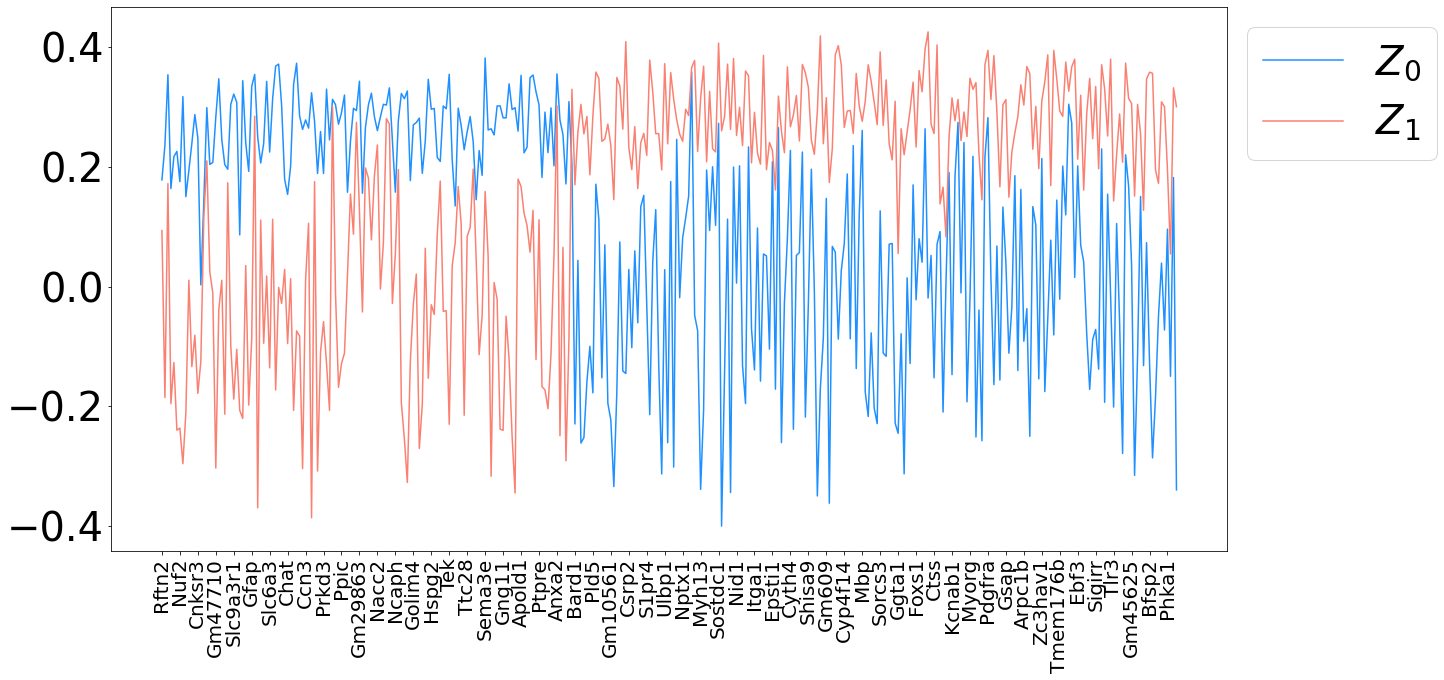

In [428]:
gene_labels = list(genes_cluster_u['idx_0']) + list(genes_cluster_u['idx_1'])
num_genes = len(gene_labels)


plt.figure(figsize = (20,10))

plt.plot(factor_loadings_ur[:num_genes,0],linewidth = 1.5,color='dodgerblue',label = '$Z_0$')
plt.plot(factor_loadings_ur[:num_genes,1],linewidth = 1.5,color='salmon', label = '$Z_1$')
    

plt.xticks(ticks = np.arange(0,num_genes,6), labels = gene_labels[0:num_genes:6],rotation = 90, fontsize = 20)
plt.yticks(fontsize = 40)
plt.legend(fontsize = 40,bbox_to_anchor=(1.0, 1.0))

plt.savefig(f'../../results/Linear_Bursty_B08_figs/z0_z1_unspliced_weights.png',bbox_inches='tight')

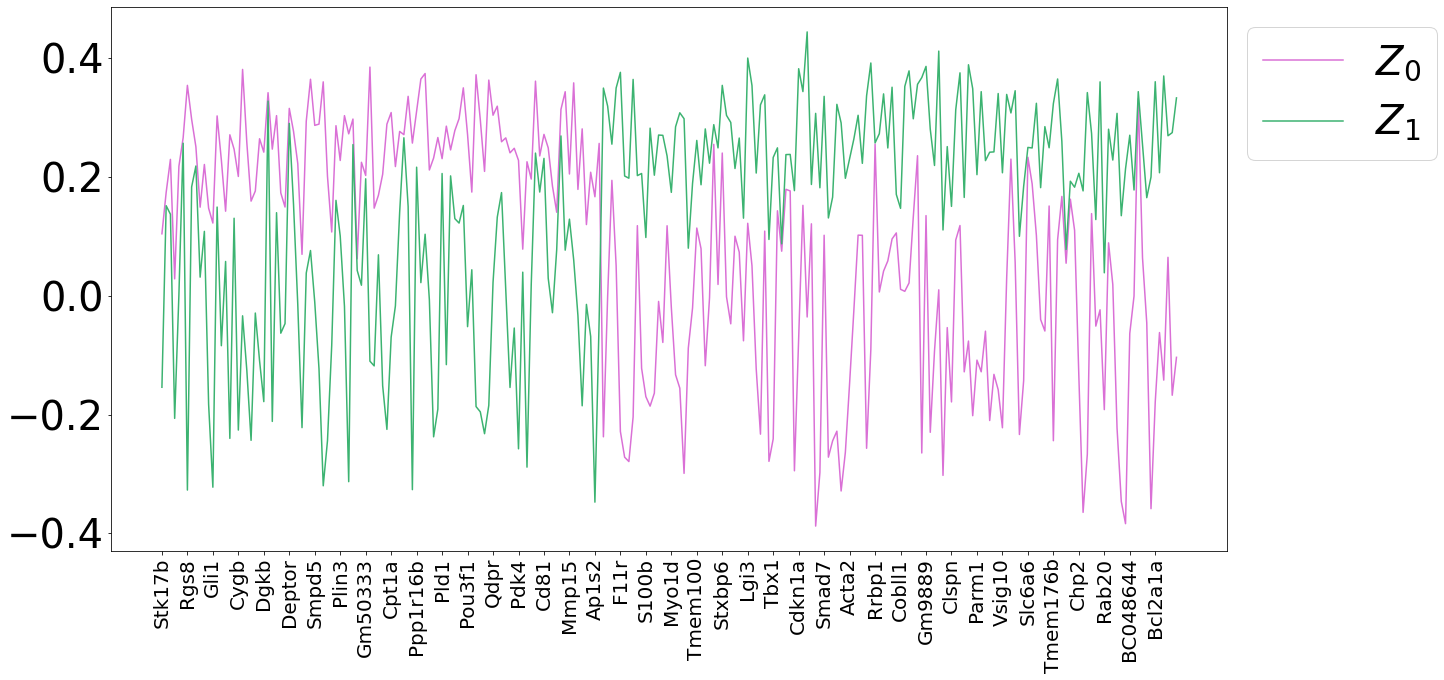

In [429]:
gene_labels = list(genes_cluster_s['idx_0']) + list(genes_cluster_s['idx_1'])
num_genes = len(gene_labels)


plt.figure(figsize = (20,10))

plt.plot(factor_loadings_sr[:num_genes,0],linewidth = 1.5,color='orchid',label = '$Z_0$')
plt.plot(factor_loadings_sr[:num_genes,1],linewidth = 1.5,color='mediumseagreen', label = '$Z_1$')
    

plt.xticks(ticks = np.arange(0,num_genes,6), labels = gene_labels[0:num_genes:6],rotation = 90, fontsize = 20)
plt.yticks(fontsize = 40)
plt.legend(fontsize = 40,bbox_to_anchor=(1.0, 1.0))

plt.savefig(f'../../results/Linear_Bursty_B08_figs/z0_z1_spliced_weights.png',bbox_inches='tight')

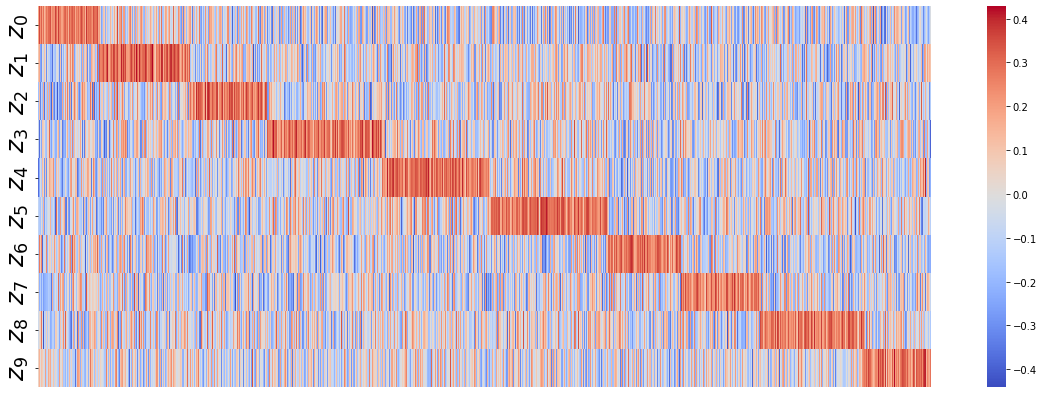

In [385]:
cmap = sns.diverging_palette(250, 30, l=65, center="dark")

# plot the "gene modules" of "coregulated genes"
genes_0_1 = list(genes_cluster_u['idx_0']) + list(genes_cluster_u['idx_1'])
fig, ax = plt.subplots(1,1,figsize = (20,7))

heatmap = sns.heatmap(factor_loadings_ur[:,:10].T,cmap="coolwarm", ax=ax, 
                      yticklabels = [f'$z_{i}$' for i in range(10)],)

heatmap.set_yticklabels(heatmap.get_yticklabels(), size = 25)
# plt.ylabel('Latent Variable', fontsize = 25)
# plt.xlabel('Genes',fontsize = 25)
# plt.title('Spliced')
ax.set_xticks([])


plt.savefig(f'../../results/Linear_Bursty_B08_figs/unspliced_weights.png',bbox_inches='tight')


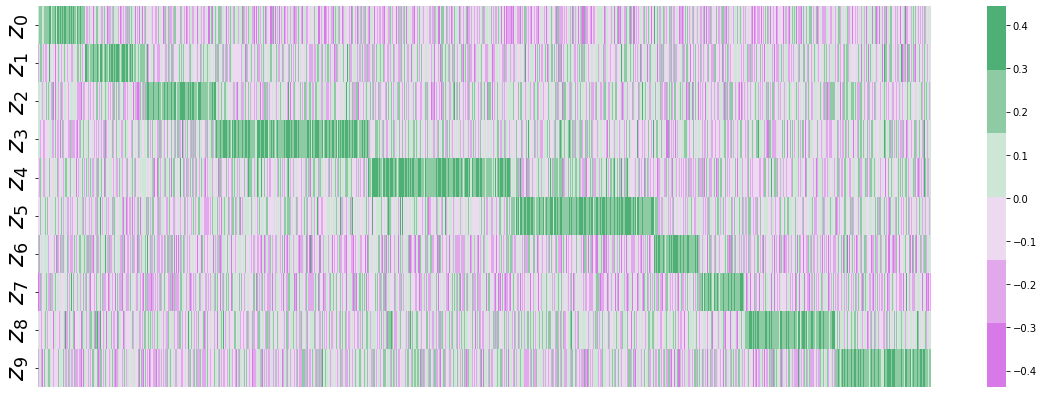

In [416]:
cmap = sns.diverging_palette(300, 140, l=65)

# plot the "gene modules" of "coregulated genes"
genes_0_1 = list(genes_cluster_u['idx_0']) + list(genes_cluster_u['idx_1'])
fig, ax = plt.subplots(1,1,figsize = (20,7))

heatmap = sns.heatmap(factor_loadings_sr[:,:10].T,cmap=cmap, ax=ax, 
                      yticklabels = [f'$z_{i}$' for i in range(10)],)

heatmap.set_yticklabels(heatmap.get_yticklabels(), size = 25)
# plt.ylabel('Latent Variable', fontsize = 25)
# plt.xlabel('Genes',fontsize = 25)
# plt.title('Spliced')
ax.set_xticks([])


plt.savefig(f'../../results/Linear_Bursty_B08_figs/spliced_weights.png',bbox_inches='tight')

In [16]:
# reorder x based on cell type 
X_linear_ordered = np.zeros_like(X_linear)

num_done = 0
for ct in np.unique(cell_types):
    print(ct)
    idx_ = cell_types == ct
    num_ = np.sum(idx_)
    print(num_)
    X_linear_ordered[num_done:num_done+num_,:] = X_linear[idx_,:]
    num_done += num_

Astro
49
Endo
21
L2/3 IT
823
L5 IT
2395
L5/6 NP
251
L6 CT
1333
L6 IT
489
L6b
66
Lamp5
192
Macrophage
17
OPC
17
Oligo
82
Pvalb
114
Sncg
45
Sst
271
Vip
233


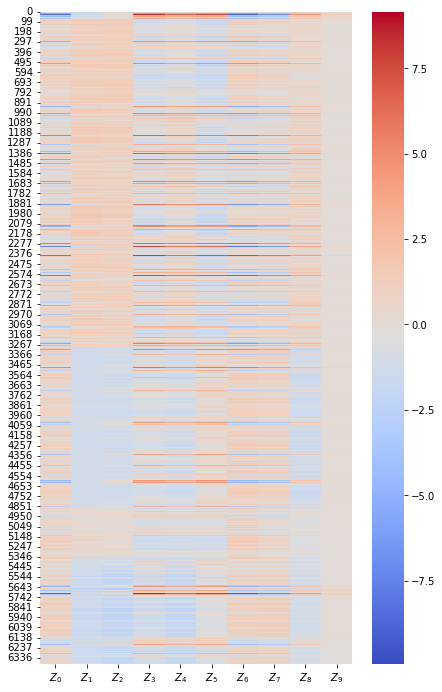

In [293]:
# plot the "gene modules" of "coregulated genes"

fig, ax = plt.subplots(1,1,figsize = (7,12))

heatmap = sns.heatmap(X_linear_ordered,cmap="coolwarm", ax=ax,
                      xticklabels = [f'$Z_{i}$' for i in range(10)])

2587


<AxesSubplot:>

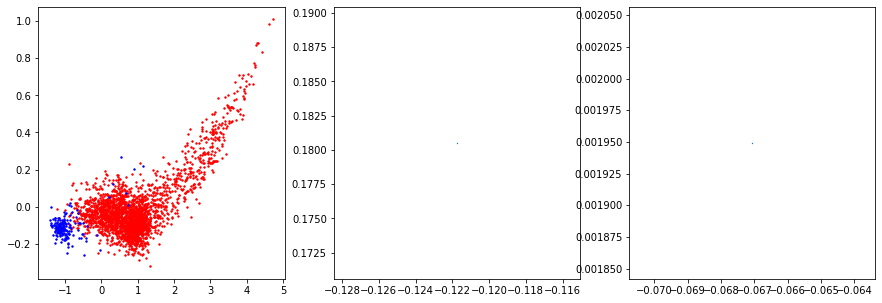

In [257]:
# Pull out clusters 
c1 = 8
c2 = 9

ct1 = 'L5 IT'
ct2 = 'Lamp5'

idx_ct1 = cell_types == ct1
idx_ct2 = cell_types == ct2

idx  = idx_ct1 | idx_ct2
print(sum(idx))

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].scatter(x = X_linear[idx_ct1,c1],y = X_linear[idx_ct1,c2], s = 2,color = 'red')
ax[0].scatter(x = X_linear[idx_ct2,c1],y = X_linear[idx_ct2,c2], s = 2,color = 'blue')

sns.scatterplot(x = factor_loadings_u[1035:1035+1,c1],y = factor_loadings_u[1035:1035+1,c2], s = 2, ax = ax[1])

sns.scatterplot(x = factor_loadings_s[1035:1035+1,c1],y = factor_loadings_s[1035:1035+1,c2], s = 2, ax = ax[2])


In [253]:
genes  = np.array(adata.var.gene_name.tolist())

In [254]:
np.where(genes == 'Lamp5')

(array([1035, 3035]),)


# Gene ontology

Plugged some of the above into GO to find biological processes they are involved in. 



Choose some top results to plot. 

### Unspliced

In [28]:
# first group
for g in genes_cluster_u['idx_9']:
    print(g)

Rgs2
Rgs4
Resp18
Nav1
Rgs8
Sulf1
Pcp4l1
Sash1
Ntn4
Cd63
Plekhg1
Adora2a
Gm2a
Rnd2
Timp2
Adora2b
Egfr
Mrc2
Brip1
Atp1b2
Ccdc69
Ggt6
Ebf1
Mir142hg
Id2
Fos
Egln3
Flvcr2
Slc25a21
Sp8
Rhob
Sox11
Serpinb6b
Nrsn1
Hist1h2ac
Egr3
Dock5
Cldn10
Zic2
Zfp488
Il7r
Slc1a3
Ly6c1
Lifr
Serhl
Ncf4
Rapgef3
Phldb2
Cldn5
Eef1akmt4
Gm34256
Slc9a3r2
Ly6g6e
Lbh
Qk
Gm26510
Csf1r
Colec12
Tnfaip8
Slc12a2
Gm15972
Cemip2
Scd2
Acta2
Rorb
Opalin
Ppp1r3c
Itprip
Tjp2
Ifit1
Mertk
Stom
Ccdc141
Ermn
Matn4
Cers2
Serpini1
S100a11
Enpep
Ifi44
F3
Rnf13
Igsf3
S100a13
A730020M07Rik
Mecom
Frem2
I830077J02Rik
Ndst4
Gm26544
Nr4a3
Nfib
Tmem82
Cnr1
Plpp3
Mob3b
Pou3f2
Fgfrl1
Lgi2
Micall2
Hrk
Garem2
Speer4a
Cux2
Foxp2
Pon3
Slco1c1
Slc6a1
Pde3a
Gpr37
Kcna1
Gimap5
Pon2
Cd8b1
Abcc9
Ptprz1
Th
Htra1
Kcnc1
Pde8a
Homer2
Il21r
Hif3a
Lgi4
Thrsp
E2f8
Gpr4
Sirt2
Fes
Rhog
Trim30c
Rab11fip1
Npy1r
Pcolce2
Ets1
Tent5a
Plscr4
Cspg5
Myo6
Tmprss5
Rpp25
Fxyd6
Colca2
1700063D05Rik
Mid1ip1
Slc38a5
Klhl13
Apln
Zcchc12
1700013H16Rik


In [47]:
process_u = ['GABA import',
             'Macrophage differentiation',
             'Long-term synaptic potentiation',
             'AMPA receptor activity',
             'Hippocampal neuron apopotosis',
             'Cdc42 protein signal transduction',
             'Angiogenesis',
             'Interleukin-8 production',
             'Notochord regression',
             'Glycine import'
             ]
FE_u = [100,23.17,34.37,32.59,100,33.13,7.3,9.28,100,100]
p_u = [6.21e-6,4.48e-4,1.58e-4,2.11e-4,5.63e-4,2.14e-4,6.09e-6,2.70e-4,5.32e-4,2.4e-4]
num_u = [len(genes_cluster_u[f'idx_{i}']) for i in range(10)]


In [78]:
df_plot = pd.DataFrame({'Biological process' : process_u,
           'Fold enrichment' : FE_u, 
           'Number per cluster' : num_u,
           'Cluster_Id' : [f'$z_{i}$' for i in range(10)],
           '-log10 p' : -np.log10(p_u)})

In [79]:
df_plot

,Biological process,Fold enrichment,Number per cluster,Cluster_Id,-log10 p
0,GABA import,100.00,137,$z_0$,5.206908
1,Macrophage differentiation,23.17,203,$z_1$,3.348722
2,Long-term synaptic potentiation,34.37,173,$z_2$,3.801343
3,AMPA receptor activity,32.59,257,$z_3$,3.675718
4,Hippocampal neuron apopotosis,100.00,241,$z_4$,3.249492
5,Cdc42 protein signal transduction,33.13,266,$z_5$,3.669586
6,Angiogenesis,7.30,163,$z_6$,5.215383
7,Interleukin-8 production,9.28,176,$z_7$,3.568636
8,Notochord regression,100.00,234,$z_8$,3.274088
9,Glycine import,100.00,150,$z_9$,3.619789


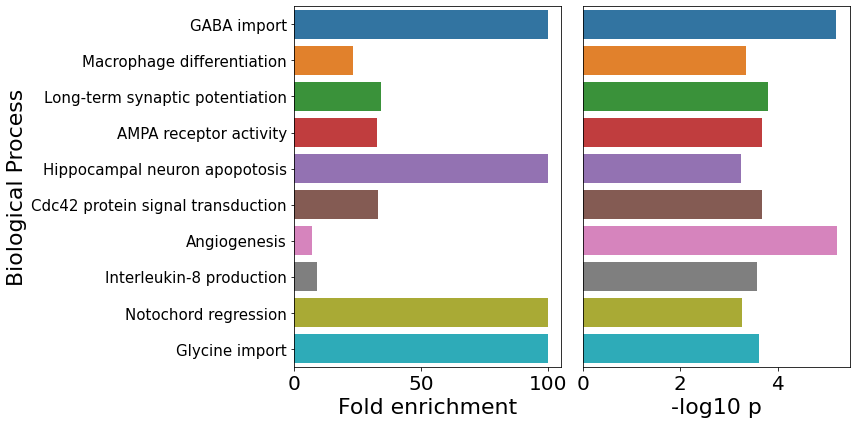

In [99]:
fig, ax = plt.subplots(1,2,figsize = (12,6))
sns.barplot(data=df_plot, y="Biological process", 
            x="Fold enrichment", ax = ax[0])
ax[0].set_ylabel('Biological Process', fontsize = 22)
ax[0].set_xlabel('Fold enrichment', fontsize = 22)
ax[0].tick_params(axis='x', which='major', labelsize=20)
ax[0].tick_params(axis='y', which='major', labelsize=15)
sns.barplot(data=df_plot, y="Biological process", 
            x="-log10 p", ax = ax[1])
ax[1].set_yticks([])
ax[1].set_ylabel('')
ax[1].set_xlabel('-log10 p', fontsize = 22)
ax[1].tick_params(axis='x', which='major', labelsize=20)

plt.tight_layout()

plt.savefig(f'../../results/Linear_Bursty_B08_figs/GO_unspliced.png',bbox_inches='tight');

<ipython-input-101-7cf0d48d9625>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


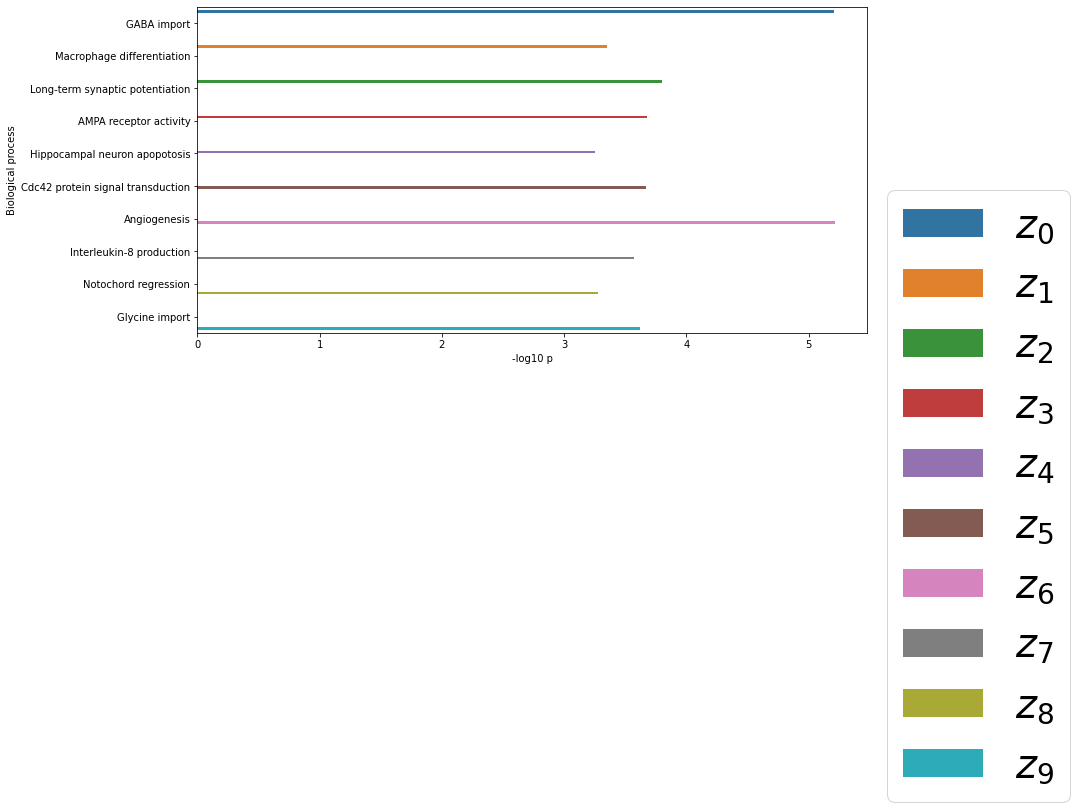

In [101]:
fig, ax = plt.subplots(1,1,figsize = (12,6))

sns.barplot(data=df_plot, y="Biological process", 
            x="-log10 p", ax = ax, hue = 'Cluster_Id')

plt.legend(fontsize = 40,bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()

plt.savefig(f'../../results/Linear_Bursty_B08_figs/GO_unspliced_label.png',bbox_inches='tight');

# Training results



In [432]:
model_linear.history.keys()

dict_keys(['train_loss_step', 'validation_loss', 'elbo_validation', 'kl_global_validation', 'kl_local_validation', 'reconstruction_loss_validation', 'train_loss_epoch', 'elbo_train', 'kl_global_train', 'kl_local_train', 'reconstruction_loss_train'])

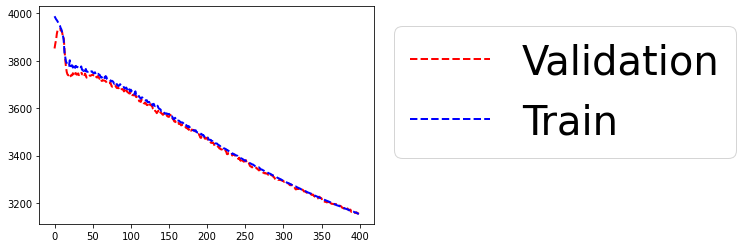

In [439]:
plt.plot(model_linear.history['validation_loss'],linewidth = 2.0, linestyle= '--', color = 'red',label='Validation')
plt.plot(model_linear.history['train_loss_epoch'],linewidth = 2.0, linestyle= '--', color = 'blue',label='Train')
plt.legend(bbox_to_anchor = (1.0,1.0));